In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset


sys.path.insert(0, r'G:\My Drive\DNN')
from collections.abc import Callable
from typing import Literal
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
print (fn_plot_torch_hist.__doc__)

None


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './torch_models'
subDir = 'fashion'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [7]:
trainfilepath = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
testfilepath = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(trainfilepath)
test_df = pd.read_csv(testfilepath)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
class_labels = {0: 'T-shirt/top',
            1: 'Trouser', 
            2: 'Pullover', 
            3:'Dress', 
            4:'Coat', 
            5:'Sandal', 
            6:'Shirt', 
            7:'Sneaker',
            8:'Bag', 
            9:'Ankle boot'}

In [9]:
class GlobalScalar:
    _instance =None

    def __init__(self) -> None:
        if GlobalScalar._instance is not None:
            raise Exception ('GlobalScalar class in Singleton')
        
        self.scaler = StandardScaler()

    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = GlobalScalar()
        return cls._instance

In [10]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [11]:
class FashionDS(Dataset):
    globalScalar = GlobalScalar.get_instance()

    def __init__(self, 
                 dataframe: pd.DataFrame,
                 device: str = device):

        self.df = dataframe
        self.device = device
        
        self.labels = self.df['label'].to_numpy()
        X = self.df.drop('label', axis = 1).to_numpy()

        self.features = X/255

    def __len__(self):
        return len(self.features)
    
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]

        # Convert to PyTorch tensors
        features = torch.tensor(features,
                                dtype=torch.float32,
                                device=self.device)
        
        label = torch.tensor(label,
                                dtype=torch.int64,
                                device=self.device)
        return features, label

In [12]:


train_ds = FashionDS(train_df)

test_ds = FashionDS(test_df)

In [13]:
train_loader = DataLoader(train_ds, 
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_loader = DataLoader(test_ds,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [14]:
images, targets = next(iter(train_loader))

images = images.cpu().numpy()

targets = targets.cpu().numpy()

targets

array([2, 4, 7, 0, 4, 7, 6, 9, 1, 9, 2, 5, 8, 1, 7, 9, 5, 5, 3, 6, 1, 7,
       6, 7, 9, 4, 4, 8, 5, 7, 0, 5], dtype=int64)

Text(0.5, 1.0, 'Sandal')

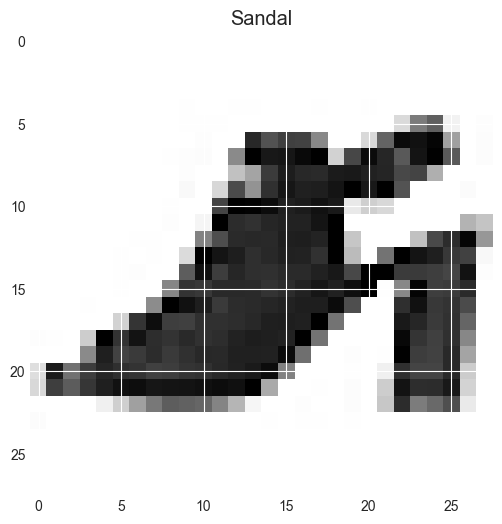

In [15]:
plt.imshow(images[31].reshape(28,28))
plt.title(class_labels[targets[31]])

In [16]:
class_labels[targets[0]]

'Pullover'

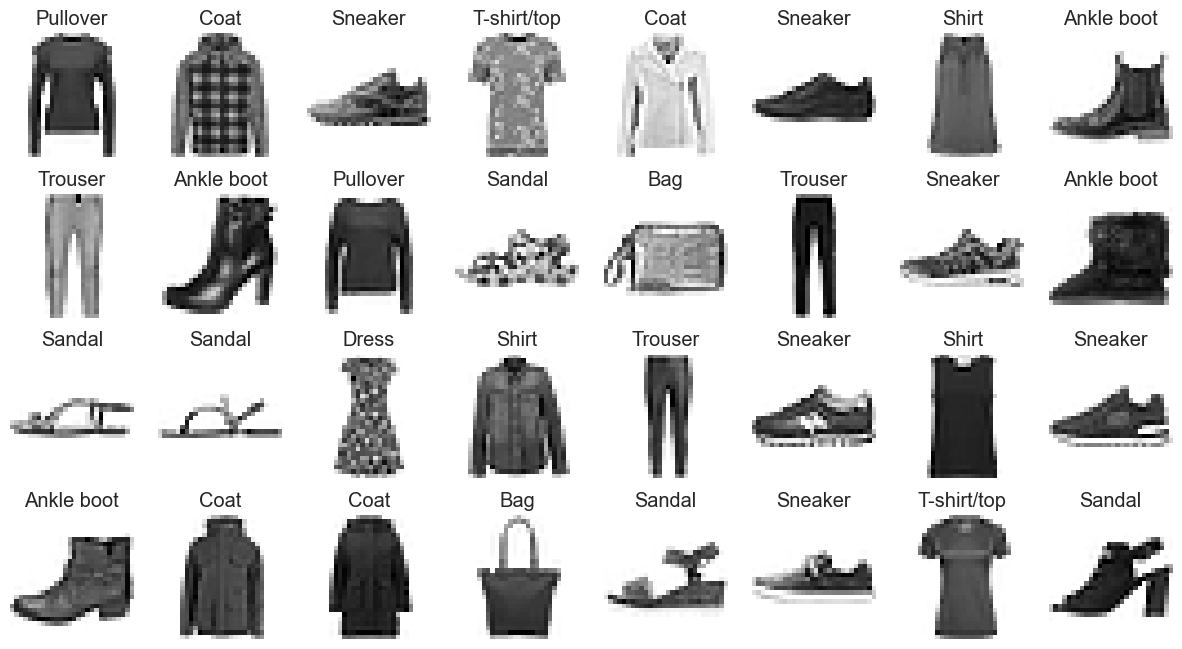

In [17]:
plt.figure(figsize = (15,8))

for i in range(BATCH_SIZE):
    plt.subplot(4,8,i+1)
    plt.imshow(images[i].reshape(28,28), cmap= plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_labels[targets[i]])
    

In [18]:
next(iter(train_ds))

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2431, 0.2392, 0.0824, 0.1137, 0.0902,
         0.2000, 0.5333, 0.2392, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [19]:
next(iter(test_ds))

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0353, 0.0314,
         0.0000, 0.0000, 0.1333, 0.1137, 0.0275, 0.0000, 0.0431, 0.0941, 0.0000,
         0.0000, 0.0118, 0.0118, 0.0039, 0.0000, 0.0039, 0.0039, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1725, 0.3451, 0.3882, 0.4784, 0.4824, 0.3137,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0039, 0.0039, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0078, 0.0000, 0.0000, 0.0000,
         0.0118, 0.1804, 0.6824, 0.9765, 0.2627, 0.0000, 0.3686, 0.8235, 0.2392,
         0.0549, 0.8314, 0.6157, 0.1451, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0078, 0.0000, 0.0902,
         0.6588, 0.8078, 0.9490, 0.9373, 0.9333, 0.8392, 0.4902, 0.2392, 0.4431,
         0.2902, 0.5216, 0.9255, 0.9333, 0.9255, 0.7961, 0.7216, 0.0784, 0.0000,
         0.0039, 0.0000, 0.0

In [20]:
input_shape = train_df.shape[1]-1
input_shape

784

In [21]:
class Model(nn.Module):

    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128) # 784 * 128 / 6
        self.activ1 = nn.Tanh()
        self.layer2 = nn.Linear(128,32) # 128 * 32 / 4
        self.activ2 = nn.Tanh()
        self.layer3 = nn.Linear(32,10) # 32 * 10 /3
        self.softmax = nn.LogSoftmax(dim = 1) # we have used Log of softmax to avoid Exploding Gradient problem

    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        x = self.layer2(x)
        x = self.activ2(x)
        x = self.layer3(x)
        return self.softmax(x)

net = Model(input_dim = input_shape).to(device)
net

Model(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (activ1): Tanh()
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (activ2): Tanh()
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [22]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:0.5252, test:0.3940 | Acc - train:0.8159, test:0.8573
At epoch 5 | Loss - train:0.2897, test:0.3391 | Acc - train:0.8931, test:0.8763
At epoch 10 | Loss - train:0.2491, test:0.3125 | Acc - train:0.9066, test:0.8869
At epoch 15 | Loss - train:0.2239, test:0.3167 | Acc - train:0.9168, test:0.8867
At epoch 20 | Loss - train:0.2037, test:0.3422 | Acc - train:0.9240, test:0.8839
At epoch 25 | Loss - train:0.1890, test:0.3396 | Acc - train:0.9304, test:0.8878
At epoch 30 | Loss - train:0.1745, test:0.3457 | Acc - train:0.9347, test:0.8885
At epoch 35 | Loss - train:0.1618, test:0.3482 | Acc - train:0.9400, test:0.8936
At epoch 40 | Loss - train:0.1520, test:0.3799 | Acc - train:0.9436, test:0.8843
At epoch 45 | Loss - train:0.1418, test:0.3690 | Acc - train:0.9485, test:0.8863
At epoch 50 | Loss - train:0.1371, test:0.4028 | Acc - train:0.9497, test:0.8881
At epoch 55 | Loss - train:0.1250, test:0.4127 | Acc - train:0.9547, test:0.8873
At epoch 60 | Loss - train:0.1

In [23]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.525214,0.393995,0.815917,0.8573
1,1,0.375784,0.402150,0.865133,0.8499
2,2,0.340424,0.354679,0.875733,0.8702
3,3,0.318424,0.340991,0.882633,0.8747
4,4,0.304482,0.334077,0.887800,0.8763


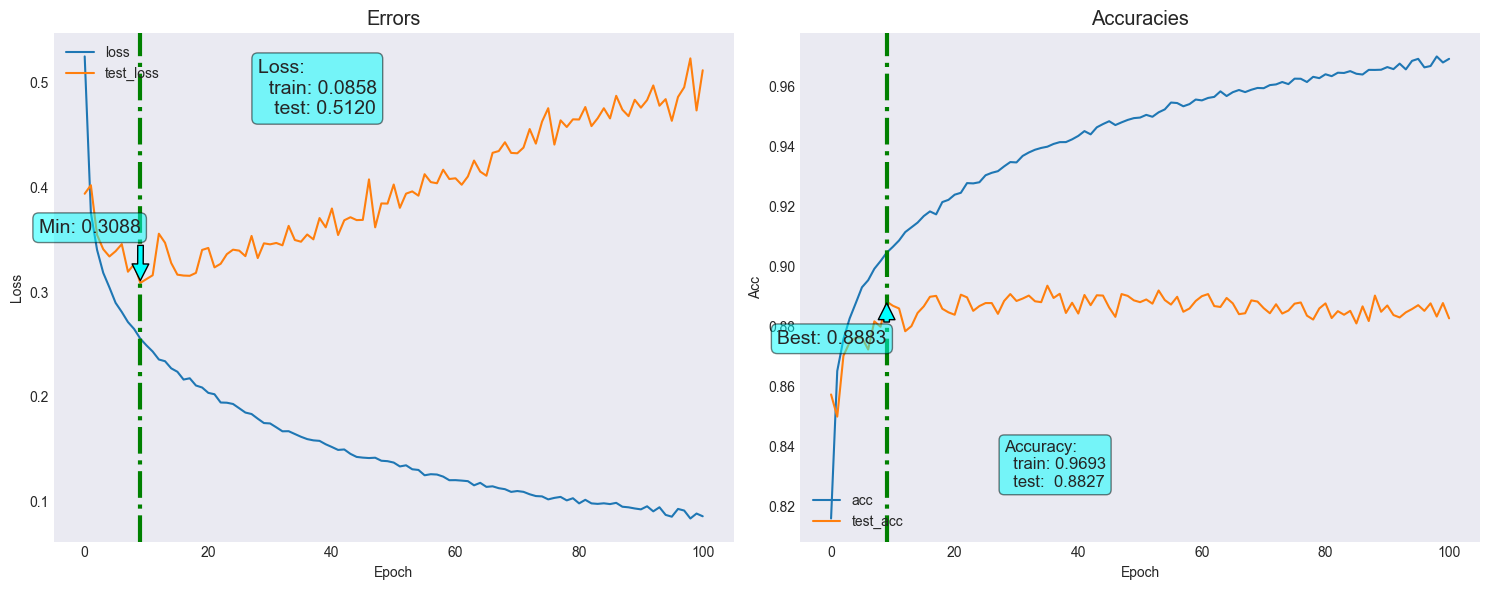

In [24]:
fn_plot_torch_hist(loss_df)

In [25]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [26]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6000
           1       1.00      1.00      1.00      6000
           2       0.96      0.89      0.92      6000
           3       0.98      0.98      0.98      6000
           4       0.87      0.97      0.92      6000
           5       1.00      1.00      1.00      6000
           6       0.97      0.84      0.90      6000
           7       0.99      1.00      0.99      6000
           8       1.00      1.00      1.00      6000
           9       1.00      0.99      0.99      6000

    accuracy                           0.96     60000
   macro avg       0.97      0.96      0.96     60000
weighted avg       0.97      0.96      0.96     60000



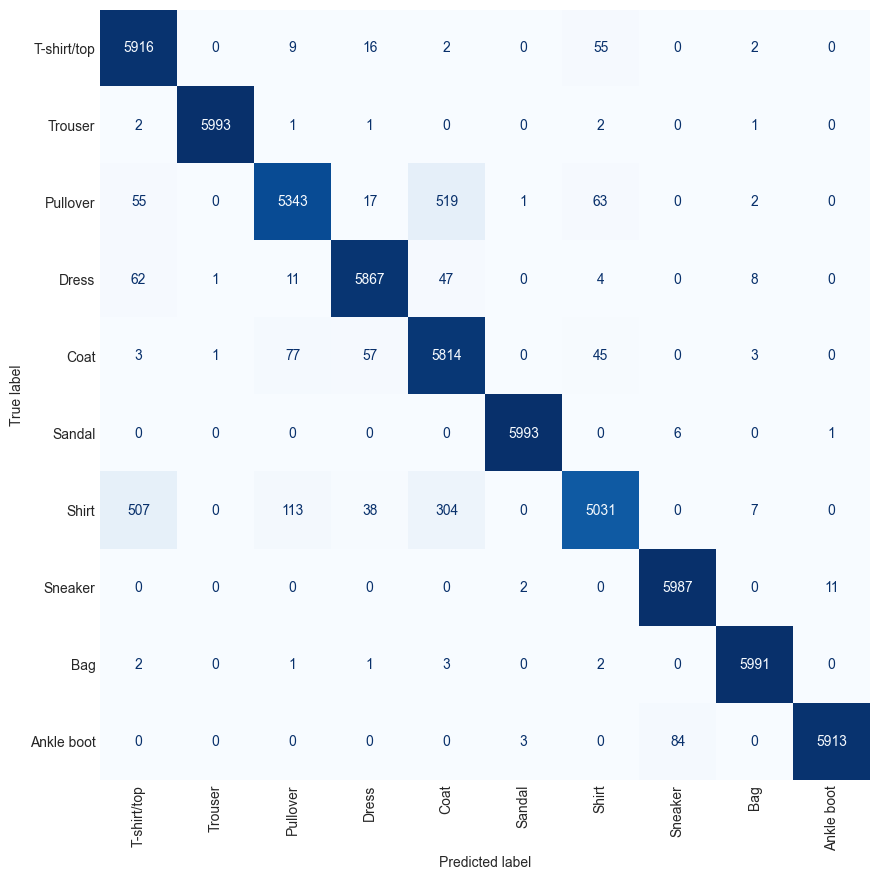

In [27]:
cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (10,10))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
plt.grid(False)
plt.show();

In [28]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_test, y_pred ))



              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.86      0.76      0.81      1000
           3       0.90      0.89      0.90      1000
           4       0.74      0.88      0.81      1000
           5       0.97      0.95      0.96      1000
           6       0.77      0.60      0.67      1000
           7       0.92      0.96      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



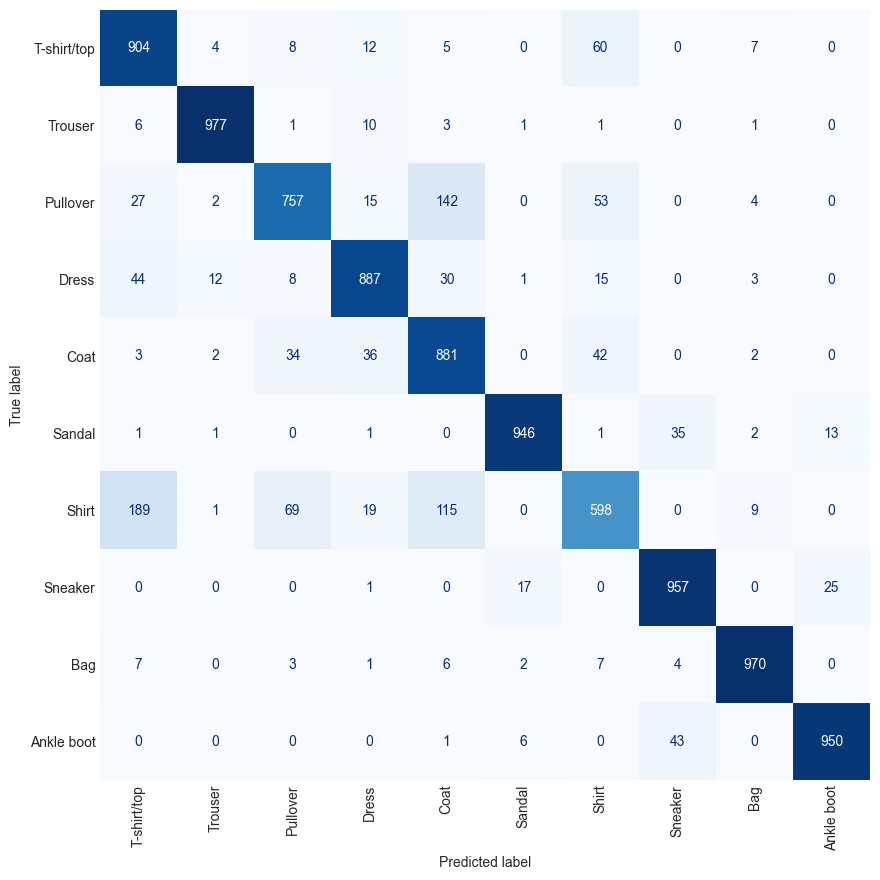

In [29]:
cm  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (10,10))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
plt.grid(False)
plt.show();

Manual simple way 

In [30]:
X = train_df.drop('label', axis=1).to_numpy() /255
X = torch.tensor(X, dtype=torch.float32).to(device)
y_true = train_df['label'].to_numpy()

In [31]:
with torch.inference_mode():
    preds =  net(X)
    y_pred = preds.argmax(dim = 1)
    y_pred = y_pred.cpu().numpy()
y_pred.shape

(60000,)

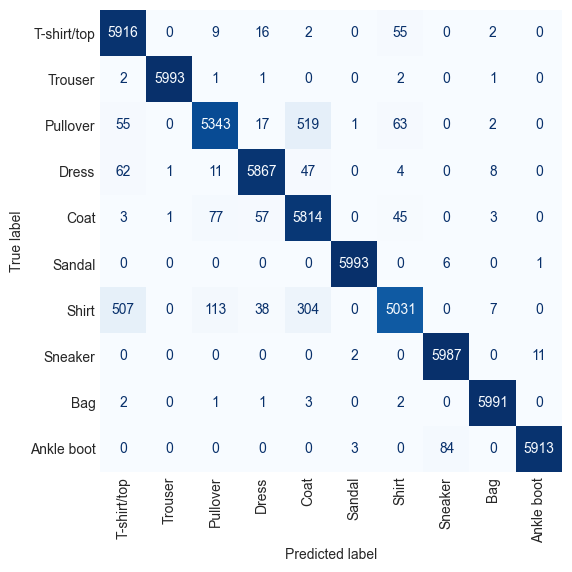

In [32]:
fn_plot_confusion_matrix(y_true, y_pred, class_labels)